Use the simple SNR model from "Design considerations for low-margin elastic optical networks in the nonlinear regime" Savory et al. with an added white Gaussian noise term, designed to alleviate the problem of significantly reducing the predictive variance of the model:
$SNR = \frac{1}{aP^{-1} + bP^2} + c$, where $a$ and $b$ determine the strength of the linear and nonlinear noise contributions and $c$ represents the TRx NSR.


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel as W
from scipy.optimize import curve_fit
from numpy.random import normal
from simple_model import simple_model
font = { 'family' : 'sans-serif',
                'weight' : 'normal',
                'size'   : 14}
matplotlib.rc('font', **font)

In [24]:
data_dir = '/Users/joshnevin/Desktop/JavierBERdata/'
snr = np.genfromtxt(open(str(data_dir) + "pchexpsnrsam100.csv", "r"), delimiter=",", dtype =float)[21:60]
pch = np.genfromtxt(open(str(data_dir) + "pchexppchsam100.csv", "r"), delimiter=",", dtype =float)[21:60]
# snr = np.genfromtxt(open(str(data_dir) + "pchexpsnrsam300.csv", "r"), delimiter=",", dtype =float)
# pch = np.genfromtxt(open(str(data_dir) + "pchexppchsam300.csv", "r"), delimiter=",", dtype =float)

In [25]:
down_sample_factor = 1  # currently doing nothing 
snr = np.array([snr[i] for i in range(len(snr)) if i % down_sample_factor == 0])
pch = np.array([pch[i] for i in range(len(pch)) if i % down_sample_factor == 0])
snr_lin = 10**(snr/10)
pch_lin = 1e-3*10**(pch/10)

In [26]:
len(pch)

39

Select a fraction of the data to use for fitting and another fraction for testing.

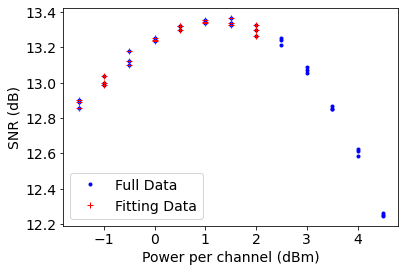

In [28]:
snr_fit = snr[:-15]
pch_fit = pch[:-15]
plt.plot(pch, snr, 'b.', label='Full Data')
plt.plot(pch_fit, snr_fit, 'r+', label='Fitting Data')
plt.xlabel("Power per channel (dBm)")
plt.ylabel("SNR (dB)")
plt.legend()
plt.show()

In [30]:
sim_model = simple_model()

In [31]:
opt_vals = sim_model.fit(pch.reshape(len(pch),), snr.reshape(len(pch),), init_guess = np.array([1e-5, 1e3, 1e0]))

In [32]:
a_opt, b_opt, c_opt = opt_vals[0]
print(a_opt)
print(b_opt)
print(c_opt)

8.649960649143029e-05
18853.45723448648
11.638679100786945


Parameter 1 std dev estimates

In [33]:
a_opt_err, b_opt_err, c_opt_err = np.sqrt(np.diag(opt_vals[1]))
print(a_opt_err)
print(b_opt_err)
print(c_opt_err)

1.997495862912613e-06
611.5478481441817
0.2219032796725062


In [34]:
snr_sim = sim_model.predict(pch, a_opt, b_opt, c_opt)
snr_sim_p1 = sim_model.predict(pch, a_opt + a_opt_err, b_opt + b_opt_err, c_opt + c_opt_err)
snr_sim_n1 = sim_model.predict(pch, a_opt - a_opt_err, b_opt - b_opt_err, c_opt - c_opt_err)

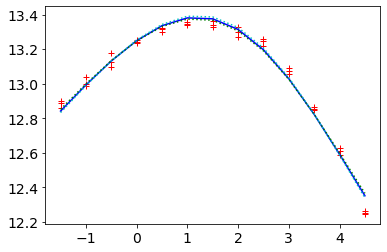

In [35]:
plt.plot(pch, snr, 'r+')
plt.plot(pch, snr_sim, 'b-')
plt.plot(pch, snr_sim_p1, 'g:')
plt.plot(pch, snr_sim_n1, 'c:')
plt.show()

Variation of 1 sigma of the fitted parameters leads to almost no variation in the predictions...

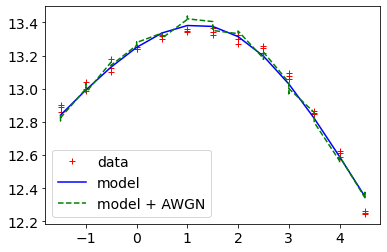

In [36]:
snr_sim_noise = snr_sim.reshape(len(snr_sim),) + np.random.normal(0, 0.03, len(pch))
plt.plot(pch, snr, 'r+', label='data')
plt.plot(pch, snr_sim, 'b-', label='model')
plt.plot(pch, snr_sim_noise, 'g--', label='model + AWGN')
plt.legend()
plt.show()

Fit GP with and without simple physical model and compare results...

In [37]:
num_points_phys = 50 #len(snr)
pch_test = np.linspace(pch[0], pch[-1], num_points_phys).reshape(-1,1) 
#snr_phys_test = sim_model.predict(pch_test, a_opt, b_opt, c_opt).reshape(-1,1)
snr_phys_test = sim_model.predict(pch_test, a_opt, b_opt, c_opt).reshape(len(pch_test),) + np.random.normal(0, 0.03, len(pch_test))
snr_phys_test = snr_phys_test.reshape(-1,1)

In [38]:
pch_fit = pch_fit.reshape(-1, 1)  # needed for SK learn input
#pch_predict = np.linspace(pch_shifted[0], pch_shifted[-1] + 1.0)
pch = pch.reshape(-1,1)
snr_fit = snr_fit.reshape(-1,1)
kernel_sk = C(1, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5)) +  W(1, (1e-8,1e5))
gpr_phys = GaussianProcessRegressor(kernel=kernel_sk, n_restarts_optimizer = 20, normalize_y=True)
gpr_phys.fit_phys(pch_fit, pch_test, snr_fit, snr_phys_test)
#print("Optimised kernel: %s" % gpr.kernel_)
mu_sk_phys, std_sk_phys = gpr_phys.predict(pch, return_std=True)
std_sk_phys = np.reshape(std_sk_phys,(np.size(std_sk_phys), 1)) 
theta_phys = gpr_phys.kernel_.theta
lml_phys = gpr_phys.log_marginal_likelihood()
mu_sk_p2_phys = mu_sk_phys + 2*std_sk_phys 
mu_sk_n2_phys = mu_sk_phys - 2*std_sk_phys 

In [39]:
pch_fit = pch_fit.reshape(-1, 1)  # needed for SK learn input
pch = pch.reshape(-1, 1)  # needed for SK learn input
kernel_sk =   C(1, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5)) + W(1, (1e-8,1e5))
gpr = GaussianProcessRegressor(kernel=kernel_sk, n_restarts_optimizer = 20, normalize_y=True)
gpr.fit(pch_fit, snr_fit)
#print("Optimised kernel: %s" % gpr.kernel_)
mu_sk, std_sk = gpr.predict(pch, return_std=True)
std_sk = np.reshape(std_sk,(np.size(std_sk), 1)) 
theta = gpr.kernel_.theta
lml = gpr.log_marginal_likelihood()
mu_sk_p2 = mu_sk + 2*std_sk 
mu_sk_n2 = mu_sk - 2*std_sk 

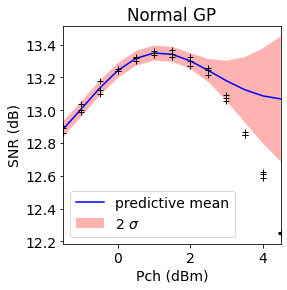

In [40]:
f, ax = plt.subplots()
ax.plot(pch, mu_sk, 'b-', label = 'predictive mean')
ax.plot(pch, snr,'k+')
#ax.plot(pch_shifted, snr_phys, 'g--', label = 'GN model')
ax.fill(np.concatenate([pch, pch[::-1]]),
            np.concatenate([mu_sk_p2,
                            (mu_sk_n2)[::-1]]),
            alpha=0.3, fc='r', ec='None', label='2 $\sigma$')
plt.xlim(pch[0], pch[-1])
plt.xlabel("Pch (dBm)")
plt.ylabel("SNR (dB)")
plt.title("Normal GP")
plt.legend()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
#plt.savefig('.pdf', dpi=200,bbox_inches='tight')
plt.show()

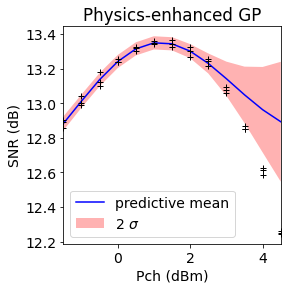

In [41]:
f, ax = plt.subplots()
ax.plot(pch, mu_sk_phys, 'b-', label = 'predictive mean')
ax.plot(pch, snr,'k+')
#ax.plot(pch_shifted, snr_phys, 'g--', label = 'GN model')
ax.fill(np.concatenate([pch, pch[::-1]]),
            np.concatenate([mu_sk_p2_phys,
                            (mu_sk_n2_phys)[::-1]]),
            alpha=0.3, fc='r', ec='None', label='2 $\sigma$')
plt.xlim(pch[0], pch[-1])
plt.xlabel("Pch (dBm)")
plt.ylabel("SNR (dB)")
plt.title("Physics-enhanced GP")
plt.legend()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
#plt.savefig('.pdf', dpi=200,bbox_inches='tight')
plt.show()

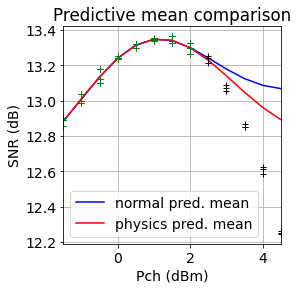

In [42]:
f, ax = plt.subplots()
ax.plot(pch, mu_sk, 'b-', label = 'normal pred. mean')
ax.plot(pch, mu_sk_phys, 'r-', label = 'physics pred. mean')
ax.plot(pch, snr,'k+')
ax.plot(pch_fit, snr_fit, 'g+')
#ax.plot(pch_shifted, snr_phys, 'g--', label = 'GN model')
plt.xlim(pch[0], pch[-1])
plt.xlabel("Pch (dBm)")
plt.ylabel("SNR (dB)")
plt.title("Predictive mean comparison")
plt.legend()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.grid()
#plt.savefig('.pdf', dpi=200,bbox_inches='tight')
plt.show()

In [43]:
max(std_sk)

array([0.1911031])

In [44]:
max(std_sk_phys)

array([0.17295833])

In [45]:
np.exp(theta)  # mu, l, sigma: kernel specified as mu**2 * RBF(l**2) + W(sigma)

array([4.33289323, 2.35425334, 0.01735402])

In [46]:
np.exp(theta_phys)  # mu, l, sigma: kernel specified as mu**2 * RBF(l**2) + W(sigma)

array([10.60436868,  3.15708008,  0.01222902])

**Observations:**
* Adding AWGN to the physical model helps to mitigate the reduction in the predictive variance of the model that is seen, as now the physical model has noise associated with it
* Increasing the number of targets generated by the physical model still has the effect of decreasing the variance, even when noise is added to the physical model
* The noise level of the data is not uniform w.r.t. power, which is what is being assumed in the physical model with AWGN. 
* The fewer datapoints used in the nonlinear regime for fitting, the greater the difference between the two models when attempting to predict in the nonlinear regime. We can interpret this as follows: without any physical model, the GP that is shown only data from the linear regime doesn't know about the nonlinear physics of the system and thus fails to accurately predict in this region. With the physical model however, the GP has a priori knowledge of the 1/P^2 regime meaning that it does better in its predictions here.
* Providing physical model estimates for the prediction range only gives worse results.